In [43]:
import numpy as np
import requests
import pandas as pd
import seaborn as sns

In [44]:
# Read in the two restaurants' daily data
url = 'https://s3.us-east-2.amazonaws.com/example.data/fish_restaurant.xls'

low_waste = pd.read_excel(url, sheet_name = 'Low-waste Restaurant', skiprows = 9)
high_waste = pd.read_excel(url, sheet_name = 'High-waste Restaurant ', skiprows = 9)

# Combine the low waste and high waste data into a single dataframe
low_waste['restaurant'] = 'low_waste'
high_waste['restaurant'] = 'high_waste'
fish = pd.concat([low_waste, high_waste], axis=0).reset_index(drop=True)

### Explore the restaurants' daily sales distributions

In [45]:
low_waste.Sales.describe()

count    360.000000
mean     385.177778
std       22.265217
min      297.000000
25%      377.000000
50%      400.000000
75%      400.000000
max      400.000000
Name: Sales, dtype: float64

In [46]:
high_waste.Sales.describe()

count    360.000000
mean     376.200000
std       55.426571
min      149.000000
25%      336.750000
50%      405.000000
75%      420.000000
max      420.000000
Name: Sales, dtype: float64

Text(0.5, 1.0, 'Distribution of Daily Fish Sales by Restaurant')

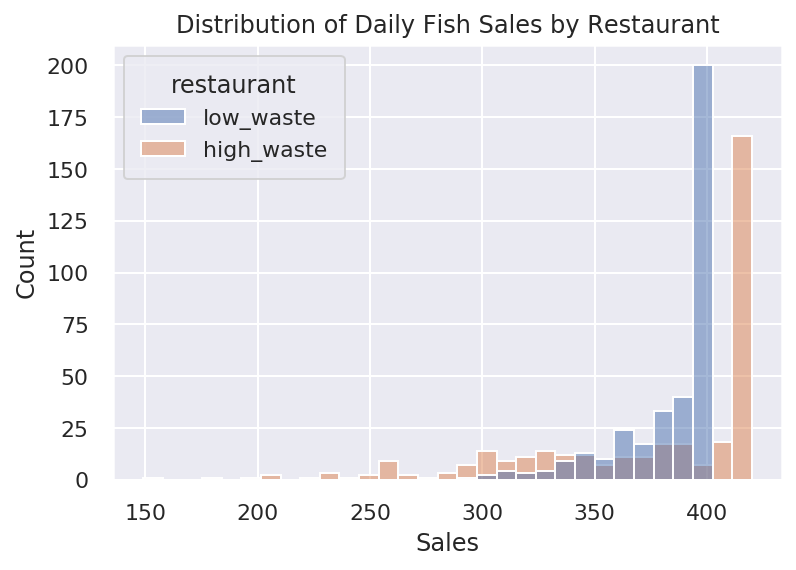

In [47]:
ax = sns.histplot(data = fish, 
                x = 'Sales',
                hue = 'restaurant')
ax.set_title('Distribution of Daily Fish Sales by Restaurant')

In [48]:
# Calculate the percent of total days that each restaurant's fish sales are capped by their daily order counts
fish['capped_days'] = np.where(fish['Sales'] == fish.groupby('restaurant')['Sales'].transform(np.max), 1, 0)
fish.groupby('restaurant').capped_days.sum() / fish.groupby('restaurant').Day.count()

restaurant
high_waste    0.411111
low_waste     0.513889
dtype: float64

### Question
Holding all other variables constant, should Fenmark Fish Restaurant reduce their restaurants' static, daily order sizes in order to maximize profits?


### Approach to Answer
Calculate and compare what the previous year's profits would have been at every possible daily order count between 1 and each restaurant's respective, current daily order count.

In [49]:
# Set static parameters
revenue_pf = 15 # revenue per fish
cost_pf = 6 # cost per fish

In [50]:
# Looping function of different order count iterations for each restaurant

proformas = pd.DataFrame()

for focal_restaurant in list(fish.restaurant.drop_duplicates()):
  
  focal = fish[fish['restaurant'] == focal_restaurant].reset_index(drop=True)

  order_size = []
  sales = []
  wastage = []
  revenue = []
  cost = []
  profit = []

  for i in range(1, max(focal.Sales+1)):
    
    '''
    For every day:
      - The new daily sales is the lesser of either the daily order count iteration
        or the actual sales for that day.
      - The new daily wastage is the lesser of either the daily order count iteration
        
    '''
    sales0 = np.sum(np.where(focal['Sales'] >= i, i, focal['Sales']))
    wastage0 = np.sum(np.where(focal['Sales'] >= i, 0, i - focal['Sales']))

    revenue0 = sales0*revenue_pf
    cost0 = sales0*cost_pf+wastage0*cost_pf
    profit0 = revenue0 - cost0
    
    order_size.append(i)
    sales.append(sales0)
    wastage.append(wastage0)
    revenue.append(revenue0)
    cost.append(cost0)
    profit.append(profit0)

  proformas0 = pd.DataFrame({'order_size': order_size,
                             'sales': sales,
                             'wastage': wastage,
                             'revenue': revenue,
                             'cost': cost,
                             'profit': profit})
  
  proformas0['restaurant'] = focal_restaurant
  
  proformas = pd.concat([proformas, proformas0])


proformas = proformas.reset_index(drop=True)

In [51]:
'''
For each restaurant and each iterated order size, 
calculate the difference in profit between the current 
iteration order size (x) and the previous iteration order size (x-1)
'''
proformas['lag'] = proformas.groupby('restaurant')['profit'].shift(1)
proformas['profit_diff'] = proformas['profit'] - proformas['lag']

In [52]:
proformas.head(10)

,order_size,sales,wastage,revenue,cost,profit,restaurant,lag,profit_diff
0,1,360,0,5400,2160,3240,low_waste,NaN,NaN
1,2,720,0,10800,4320,6480,low_waste,3240.0,3240.0
2,3,1080,0,16200,6480,9720,low_waste,6480.0,3240.0
3,4,1440,0,21600,8640,12960,low_waste,9720.0,3240.0
4,5,1800,0,27000,10800,16200,low_waste,12960.0,3240.0
5,6,2160,0,32400,12960,19440,low_waste,16200.0,3240.0
6,7,2520,0,37800,15120,22680,low_waste,19440.0,3240.0
7,8,2880,0,43200,17280,25920,low_waste,22680.0,3240.0
8,9,3240,0,48600,19440,29160,low_waste,25920.0,3240.0
9,10,3600,0,54000,21600,32400,low_waste,29160.0,3240.0


In [53]:
proformas.tail(10)

,order_size,sales,wastage,revenue,cost,profit,restaurant,lag,profit_diff
810,411,134013,13947,2010195,887760,1122435,high_waste,1122060.0,375.0
811,412,134179,14141,2012685,889920,1122765,high_waste,1122435.0,330.0
812,413,134344,14336,2015160,892080,1123080,high_waste,1122765.0,315.0
813,414,134506,14534,2017590,894240,1123350,high_waste,1123080.0,270.0
814,415,134667,14733,2020005,896400,1123605,high_waste,1123350.0,255.0
815,416,134824,14936,2022360,898560,1123800,high_waste,1123605.0,195.0
816,417,134979,15141,2024685,900720,1123965,high_waste,1123800.0,165.0
817,418,135133,15347,2026995,902880,1124115,high_waste,1123965.0,150.0
818,419,135284,15556,2029260,905040,1124220,high_waste,1124115.0,105.0
819,420,135432,15768,2031480,907200,1124280,high_waste,1124220.0,60.0


In [54]:
# Set visualization function
def var_proforma_compare(xvar, yvar):
  ax = sns.lineplot(data = proformas, x = xvar, y = yvar, hue = 'restaurant')
  ax.set_title(f'{xvar} vs. {yvar} by restaurant')

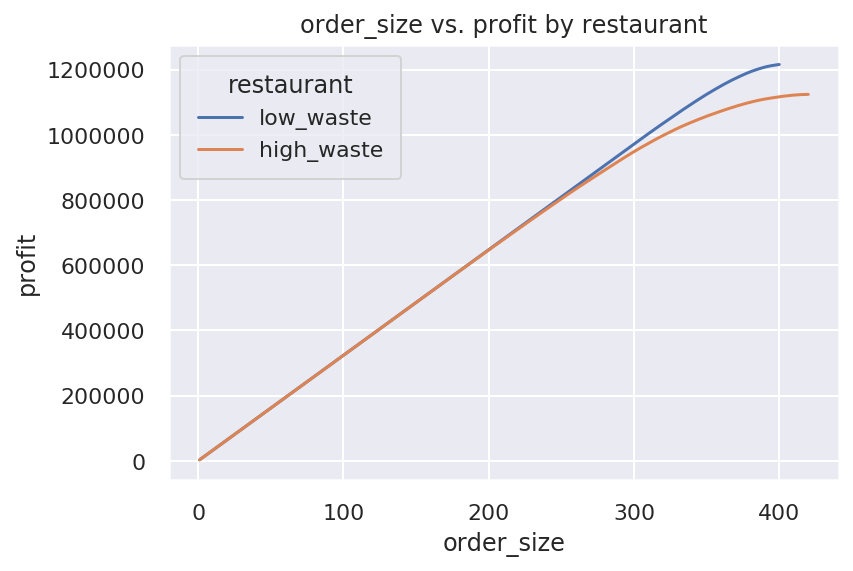

In [55]:
var_proforma_compare('order_size', 'profit')

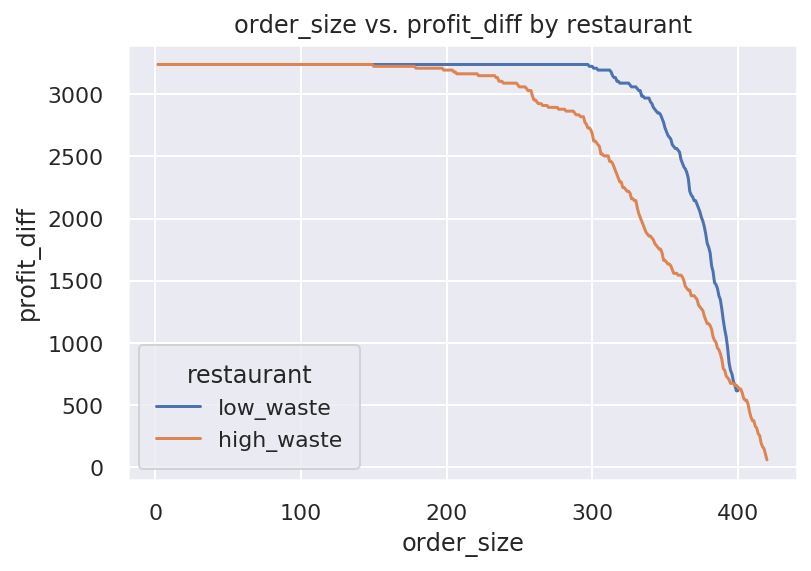

In [56]:
var_proforma_compare('order_size', 'profit_diff')

### Conclusion
Neither restaurant would be better off by decreasing the size of their daily orders. Between a daily order of 1 fish and the current daily order for each restaurant, their current daily order maximizes profits over the past year of experience.

The second plot above shows that the difference in profits between the current iteration order size (n) and the previous iteration order size (n-1). The difference in profits drops off more steeply for the "high waste" restaurant. This is due to the fact that the "low waste" restaurant's daily sales distribution has less variance than "high waste" restaurant's daily sales distribution, even though both distributions are severly underdispersed.

### Recommendation
Increase the daily fish order size for both restaurants, though not sure by how much since true fish sales demand is unknown on days where sales are currently capped by the order limit. Based on both plots above, it seems as though the "low waste" restaurant would be able to better handle a larger order increase than the "high waste" restaurant while trying to find true demand, because its distribution of daily sales has a lower variance, and it currently sells out of fish 51% of the time (vs. 41% of the time for the "high waste" restauruant).